Importing libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns

Defining the Lenet5 class

In [ ]:
class Lenet5(nn.Module):
    def __init__(self):
        super(Lenet5, self).__init__()
        self.first_conv = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.first_actfn = nn.Tanh()
        self.first_avgpl = nn.AvgPool2d(kernel_size=2, stride=2)

        self.second_conv = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.second_actfn = nn.Tanh()
        self.second_avgpl = nn.AvgPool2d(kernel_size=2, stride=2)

        self.third_conv = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.third_actfn = nn.Tanh()

        self.flat_layer = nn.Flatten()
        self.first_flcn = nn.Linear(120, 84)
        self.fourth_actfn = nn.Tanh()
        self.second_flcn = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, p):
        p = self.first_avgpl(self.first_actfn(self.first_conv(p)))
        p = self.second_avgpl(self.second_actfn(self.second_conv(p)))
        p = self.third_actfn(self.third_conv(p))
        p = self.fourth_actfn(self.first_flcn(self.flat_layer(p)))
        p = self.softmax(self.second_flcn(p))
        return p

In [ ]:
def model_train(model, train_loader, optimizer_adam, loss_fn):
    model.train()
    training_predictions = 0
    training_loss = 0
    total_samples_train = len(train_loader.dataset)

    for X_batch, y_batch in train_loader:
        optimizer_adam.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer_adam.step()
        training_loss += loss.item()
        training_predictions += (y_pred.argmax(dim=1) == y_batch).sum().item()

    train_accuracy = training_predictions / total_samples_train
    return training_loss / len(train_loader), train_accuracy

In [ ]:
def model_evaluate(model, data_loader, loss_fn):
    model.eval()
    correct_predictions = 0
    total_loss = 0
    total_samples = len(data_loader.dataset)

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            total_loss += loss_fn(y_pred, y_batch).item()
            correct_predictions += (y_pred.argmax(dim=1) == y_batch).sum().item()

    accuracy = correct_predictions / total_samples
    return total_loss / len(data_loader), accuracy

In [ ]:
def training(model, train_loader, test_loader, optimizer_adam, loss_fn, n_epochs):
    training_losses = []
    testing_losses = []
    training_accuracies = []
    testing_accuracies = []

    for epoch in range(n_epochs):
        training_loss, training_accuracy = model_train(model, train_loader, optimizer_adam, loss_fn)
        testing_loss, testing_accuracy = model_evaluate(model, test_loader, loss_fn)

        training_losses.append(training_loss)
        testing_losses.append(testing_loss)
        training_accuracies.append(training_accuracy)
        testing_accuracies.append(testing_accuracy)

        print(f"Epoch {epoch+1}:\n Training loss: {training_loss:.4f}, Testing loss: {testing_loss:.4f}, Training accuracy: {training_accuracy*100:.2f}%, Testing accuracy: {testing_accuracy*100:.2f}%\n")

    return training_losses, testing_losses, training_accuracies, testing_accuracies

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_dataset)

data = next(iter(data_loader))[0]
mean_v = data.mean()
std_v = data.std()

print(f'Mean: {mean_v.item()}')
print(f'Standard Deviation: {std_v.item()}')
print("\n")

transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_v,), (std_v,)),
])

normalized_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_normalize)
normalized_test_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_normalize)
train_loader = torch.utils.data.DataLoader(dataset = normalized_train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = normalized_test_dataset, batch_size=100, shuffle=True)

Lenet5_model = Lenet5()
loss_fn = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(Lenet5_model.parameters(), lr = 0.001)
n_epochs = 7

training_losses, testing_losses, training_accuracies, testing_accuracies = training(Lenet5_model, train_loader, test_loader, optimizer_adam, loss_fn, n_epochs)

Mean: 0.1376800686120987
Standard Deviation: 0.3125477433204651


Epoch 1:
 Training loss: 1.5898, Testing loss: 1.5087, Training accuracy: 89.42%, Testing accuracy: 95.86%

Epoch 2:
 Training loss: 1.4976, Testing loss: 1.4899, Training accuracy: 96.78%, Testing accuracy: 97.49%

Epoch 3:
 Training loss: 1.4852, Testing loss: 1.4786, Training accuracy: 97.83%, Testing accuracy: 98.42%

Epoch 4:
 Training loss: 1.4804, Testing loss: 1.4778, Training accuracy: 98.26%, Testing accuracy: 98.52%

Epoch 5:
 Training loss: 1.4773, Testing loss: 1.4750, Training accuracy: 98.51%, Testing accuracy: 98.75%

Epoch 6:
 Training loss: 1.4748, Testing loss: 1.4733, Training accuracy: 98.77%, Testing accuracy: 98.91%

Epoch 7:
 Training loss: 1.4740, Testing loss: 1.4714, Training accuracy: 98.83%, Testing accuracy: 99.06%



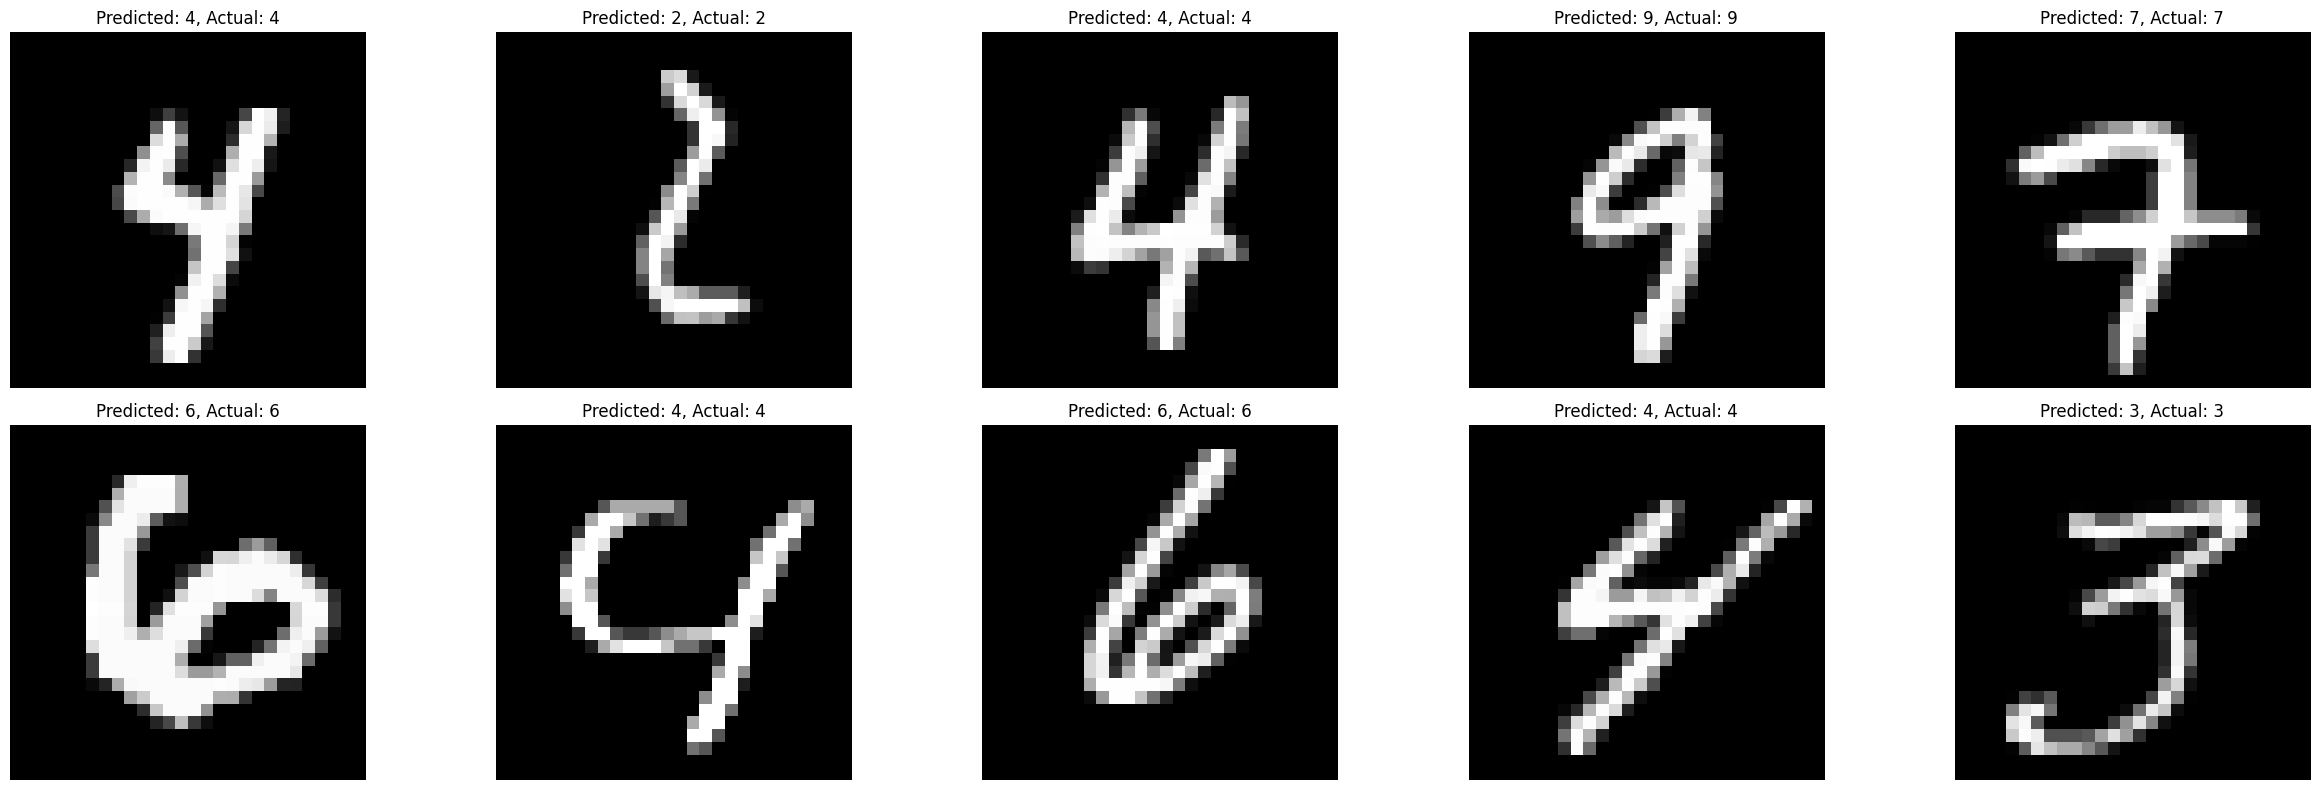

In [ ]:
def visualizing_predictions(model, data_loader, n_images=5):
    model.eval()
    n_rows = -(-n_images // 5)
    n_cols = min(n_images, 5)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 4 * n_rows))

    with torch.no_grad():
        data_iterator = iter(data_loader)
        for i in range(n_rows):
            X_batch, y_batch = next(data_iterator, (None, None))
            if X_batch is None:
                break
            y_pred = model(X_batch)
            predicted_labels = y_pred.argmax(dim=1).numpy()
            for j, (X, y, pred, ax) in enumerate(zip(X_batch, y_batch, predicted_labels, axes[i])):
                ax.imshow(X[0].numpy(), cmap='gist_gray')
                ax.set_title(f'Predicted: {pred}, Actual: {y}')
                ax.axis('off')
    plt.tight_layout()
    plt.show()

visualizing_predictions(Lenet5_model, test_loader, n_images=10)

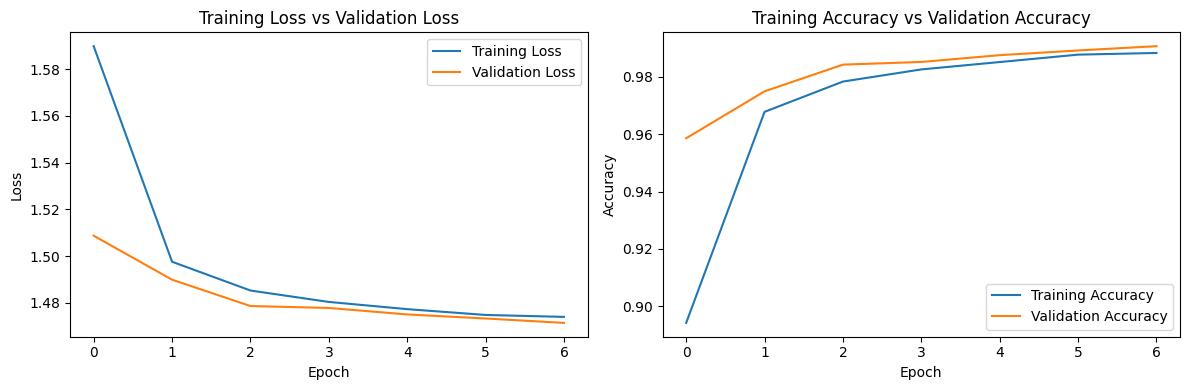

In [ ]:
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(testing_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs Validation Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(testing_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy vs Validation Accuracy')

plt.tight_layout()
plt.show()

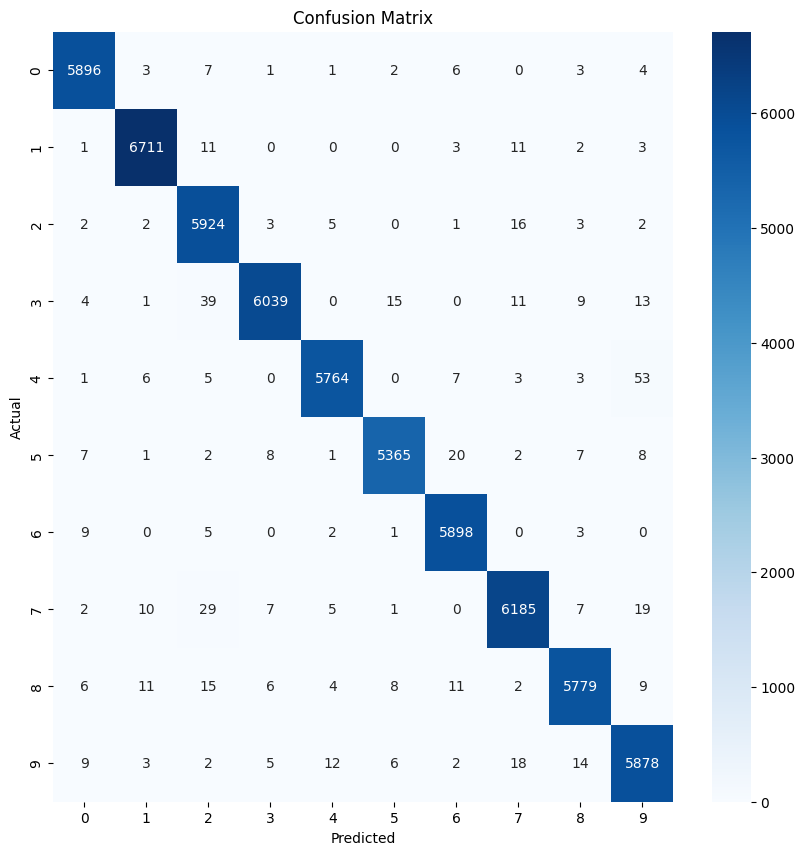

In [ ]:
def plot_confusion_matrix(model, data_loader, class_names):
    model.eval()
    data_all_labels = []
    data_all_predictions = []

    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            model_outputs = model(data_inputs)
            _, predicted = torch.max(model_outputs, 1)
            data_all_labels.extend(data_labels.numpy())
            data_all_predictions.extend(predicted.numpy())

    cm = confusion_matrix(data_all_labels, data_all_predictions)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

class_names = [str(i) for i in range(10)]
plot_confusion_matrix(Lenet5_model, test_loader, class_names)